In [1]:
#Packages
import math
from pathlib import Path 
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
with open("C:\\Users\\Uriel\\Desktop\\TP Thèse Doctoral ML\\1- CNN\\shipsnet.json") as data_file:
    dataset = json.load(data_file) # charger les données
ships = pd.DataFrame(dataset)
ships.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [3]:
# On va extraire "data et labels" pour la suite de notre étude
ships = ships[["data","labels"]]
ships.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [4]:
# 0 : pour les images avec navire
# 1 : pour les images sans navire

img_ships = ships["labels"].value_counts()[0]
img_no_ships = ships["labels"].value_counts()[1]

# Afficher le nombre d'images 

print("Nombre d'image avec navire: {}".format(img_ships),"\n")
print("Nombre d'image sans navire: {}".format(img_no_ships))

Nombre d'image avec navire: 3000 

Nombre d'image sans navire: 1000


In [5]:
# On va transformer les informations json en tableau numpy 
# et ensuite les assigner comme variables x et y

import numpy as np
x = np.array(dataset["data"]).astype("uint8")
y = np.array(dataset["labels"]).astype("uint8")

x.shape

(4000, 19200)

Les données actuelles pour chaque image sont une rangée de 19200 points de données aplaties représentant les valeurs RVB de chaque pixel. Nous devons donc les remodeler. 
Après le remodelage, chaque élément de la nouvelle variable x sera constitué,de 3 listes.
Chacune de ces listes sera constituée des valeurs RVB de chaque pixel pour la longueur et la largeur de l'image.

In [6]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0, 2, 3, 1])
x_reshaped.shape

(4000, 80, 80, 3)

On constate que la variable **y** est constituée des valeurs d'étiquettes, **1** ou **0**.
Nous allons chercher à les convertir en matrice de classe binaire.

In [7]:
from tensorflow.keras.utils import to_categorical
y.shape
y_reshaped = to_categorical(y, num_classes = 2)
y_reshaped.shape

(4000, 2)

In [8]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### **Préparation des données d'entraînement et de test**


**Etape 1** : Normalisation des données x

L'objectif de la normalisation est de modifier les valeurs des colonnes numériques du jeu de données pour utiliser une échelle commune, sans que les différences de plages de valeurs ne soient faussées et sans perte d'informations.

In [9]:
x_reshaped = x_reshaped / 255

# Normaliser les valeurs RVB du premier pixel de la première image de l'ensemble de données.
x_reshaped[0][0][0]

array([0.32156863, 0.36862745, 0.31372549])

In [10]:
# Maintenant les données sont prêtes à être divisées en données d'entrainement et de test.

x_train, x_test, y_train, y_test = train_test_split(x_reshaped, y_reshaped, test_size = 0.20, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.20, random_state = 42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)

print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)

print("y_train shape",x_validation.shape)
print("y_train shape",y_validation.shape)

x_train shape (2560, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2560, 2)
y_test shape (800, 2)
y_train shape (640, 80, 80, 3)
y_train shape (640, 2)


In [11]:
from keras import callbacks
from tensorflow.keras.models import Sequential

model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (80,80,3)))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))

# Le classificateur
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))


optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

C:\Users\Uriel\miniconda3\envs\ML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# Compilation du modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        3136      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

In [13]:
history = model.fit(x_train, y_train, epochs = 50, validation_data=(x_validation, y_validation), callbacks = [earlystopping])

#history = model.fit(x_train, y_train, epochs = 30,batch_size=32),

Epoch 1/50
80/80 [==============================] - 27s 262ms/step - loss: 0.5923 - accuracy: 0.7379 - val_loss: 0.5760 - val_accuracy: 0.7578
Epoch 2/50
80/80 [==============================] - 21s 266ms/step - loss: 0.4727 - accuracy: 0.7527 - val_loss: 0.3619 - val_accuracy: 0.7578
Epoch 3/50
80/80 [==============================] - 19s 241ms/step - loss: 0.3607 - accuracy: 0.7738 - val_loss: 0.3348 - val_accuracy: 0.8875
Epoch 4/50
80/80 [==============================] - 19s 234ms/step - loss: 0.3301 - accuracy: 0.8727 - val_loss: 0.3048 - val_accuracy: 0.8797
Epoch 5/50
80/80 [==============================] - 19s 241ms/step - loss: 0.2627 - accuracy: 0.8992 - val_loss: 0.2467 - val_accuracy: 0.9047
Epoch 6/50
80/80 [==============================] - 20s 248ms/step - loss: 0.2404 - accuracy: 0.9055 - val_loss: 0.2208 - val_accuracy: 0.9344
Epoch 7/50
80/80 [==============================] - 20s 245ms/step - loss: 0.2252 - accuracy: 0.9199 - val_loss: 0.1901 - val_accuracy: 0.9281

In [14]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 1s 55ms/step - loss: 0.0763 - accuracy: 0.9812


[0.07627221196889877, 0.981249988079071]

Text(0.5, 1.0, 'Courbe de precision(Accuracy)')

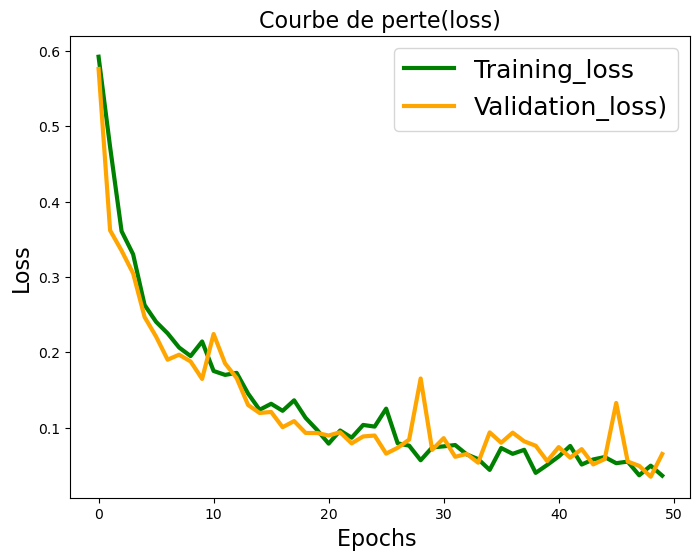

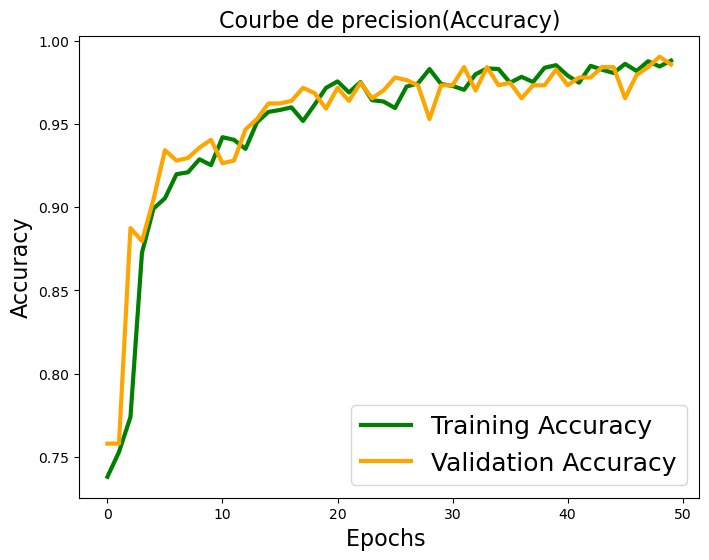

In [15]:
# Courbe de perte
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'green',linewidth=3.0)
plt.plot(history.history['val_loss'],'orange',linewidth=3.0)
plt.legend(['Training_loss', 'Validation_loss)'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Courbe de perte(loss)',fontsize=16)

# Courbe de precision(Accuracy)
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'green',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'orange',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Courbe de precision(Accuracy)',fontsize=16)

**Interpretation**

**Graphe de précision**:
D’âpres ce graphe on remarque que la précision training et du test augment avec le nombre 
d'époques.

**Graphe d’erreur** :
Ce graphe montre que l'erreur du training et du test diminue jusqu'à la première époque.

Nous lui avons fait des tests afin d’obtenir des résultats en termes de précision et d’erreur. 
L'implémentation que nous avons proposé permet de détecter les images sans navire et des images avec
navire avec un taux de précisons élevé et une erreur faible.


25/25 [==============================] - 2s 55ms/step

Test Accuracy Score :  0.98125 



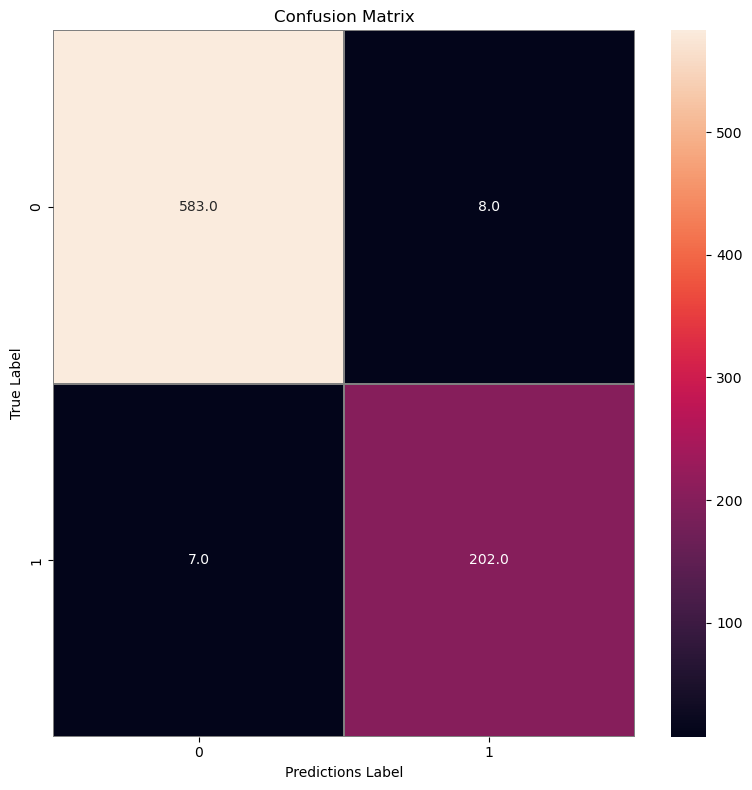

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

Y_pred = model.predict(x_test)
# Convertir les classes de prédictions en un vecteur chaud.
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convertissez les observations de validation en un vecteur chaud.
Y_true = np.argmax(y_test,axis = 1) 
# Calculer la matrice de confusion

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

# Plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predictions Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

- TP : indique que les predictions et les valeurs réelles sont positives
- TN : indique que les prediction et les valeurs réelles sont toutes les deux négatives
- FP : indique que la prediction positive est contraire à la valeur réelle qui est négative
- FN : indique que les predictions sont négatives alors que les valeurs réelles sont positives


**Nous allons tester notre model**

In [17]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Image sans navire", "Image avec navire"])

25/25 [==============================] - 1s 51ms/step


Image sans navire    0.00596
Image avec navire    0.99404
dtype: float32

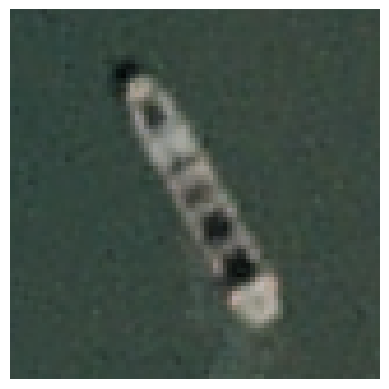

In [18]:
plt.imshow(x_test[0])
plt.axis("off")
plt.show()